In [9]:
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)


quantificators = ["CC", "ACC", "PCC", "PACC", "HDy", "EMQ","MLPE"]
error = "bias"
p_train = 0.7
ps_test = [p_train, 0.5, 0.25]
dateexperiment = "2022_06_26_07_14"


results_dict={}
order = ("2_2","3_3","4_4","3_2","2_3","4_3","3_4","4_2","2_4")
print("Loading results... ",sep="")
for quant_name in quantificators:
    results_dict[quant_name] = pd.read_csv("results/concept/results_%s_%s.csv" % (dateexperiment,quant_name),index_col=0)
    results_dict[quant_name]['MAE'] = results_dict[quant_name]['error'].abs()
    results_dict[quant_name]['cut_points'] = results_dict[quant_name]['cut_point_train'].astype(str)+'_'+results_dict[quant_name]['cut_point_test'].astype(str)
    results_dict[quant_name].cut_points = results_dict[quant_name].cut_points.astype("category")
    results_dict[quant_name]['cut_points'] = results_dict[quant_name].cut_points.cat.set_categories(order)
    results_dict[quant_name] = results_dict[quant_name].sort_values(["cut_points"])
print("Done")


mean_error_methods = {}

writer = pd.ExcelWriter('results/concept/excel/errors_%s.xlsx' % dateexperiment, engine='xlsxwriter')
for i, p_test in enumerate(ps_test):
    for quant_name in quantificators:
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        results_mean = results.groupby(['cut_point_train', 'cut_point_test'])['MAE'].mean().reset_index()
        #convert to matrix form
        results_mean = results_mean.pivot(index='cut_point_train', columns='cut_point_test', values='MAE')
        mean_error_methods[exp_id]=results_mean.mean().mean()
        print("Results for method %s. p_test: %f. Mean %s: %f" % (quant_name,p_test,error,mean_error_methods[exp_id]))
        cm = sns.light_palette('red', as_cmap=True)
        display(results_mean.style.background_gradient(cmap=cm,low=0,high=1))
        results_mean.to_excel(writer, sheet_name=exp_id)
        workbook = writer.book
        worksheet = writer.sheets[exp_id]
        # Apply a conditional format to the cell range.
        worksheet.conditional_format('B2:D4', {'type': '2_color_scale','min_type':'num','max_type':'num','min_value':'0','max_value':'1','min_color':'#f3f0f0','max_color':'#ff0000'})
writer.close()

Loading results... 
Done
Results for method CC. p_test: 0.700000. Mean bias: 0.046865


cut_point_test,2,3,4
cut_point_train,,,
2,0.018184,0.029576,0.080932
3,0.055316,0.023080,0.035996
4,0.099748,0.060236,0.018716


Results for method ACC. p_test: 0.700000. Mean bias: 0.067275


cut_point_test,2,3,4
cut_point_train,,,
2,0.016547,0.060741,0.135912
3,0.058580,0.017520,0.071544
4,0.143486,0.083772,0.017375


Results for method PCC. p_test: 0.700000. Mean bias: 0.039683


cut_point_test,2,3,4
cut_point_train,,,
2,0.012631,0.034358,0.072411
3,0.042270,0.012601,0.038202
4,0.083287,0.048434,0.012956


Results for method PACC. p_test: 0.700000. Mean bias: 0.071047


cut_point_test,2,3,4
cut_point_train,,,
2,0.015833,0.072949,0.150754
3,0.062840,0.015312,0.077289
4,0.145658,0.081411,0.017381


Results for method HDy. p_test: 0.700000. Mean bias: 0.076794


cut_point_test,2,3,4
cut_point_train,,,
2,0.025547,0.084303,0.166424
3,0.055935,0.021123,0.089980
4,0.141152,0.083782,0.022901


Results for method EMQ. p_test: 0.700000. Mean bias: 0.070401


cut_point_test,2,3,4
cut_point_train,,,
2,0.014771,0.072974,0.148349
3,0.060209,0.014758,0.080310
4,0.145546,0.081050,0.015641


Results for method MLPE. p_test: 0.700000. Mean bias: 0.000000


cut_point_test,2,3,4
cut_point_train,,,
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000


Results for method CC. p_test: 0.500000. Mean bias: 0.068596


cut_point_test,2,3,4
cut_point_train,,,
2,0.046696,0.101444,0.180368
3,0.017688,0.044864,0.114788
4,0.026980,0.023096,0.061440


Results for method ACC. p_test: 0.500000. Mean bias: 0.077241


cut_point_test,2,3,4
cut_point_train,,,
2,0.020222,0.073352,0.190370
3,0.061607,0.020046,0.096927
4,0.127483,0.085548,0.019611


Results for method PCC. p_test: 0.500000. Mean bias: 0.088386


cut_point_test,2,3,4
cut_point_train,,,
2,0.090596,0.134862,0.194583
3,0.036420,0.070401,0.132470
4,0.015377,0.036033,0.084728


Results for method PACC. p_test: 0.500000. Mean bias: 0.081386


cut_point_test,2,3,4
cut_point_train,,,
2,0.017303,0.078882,0.195373
3,0.071929,0.020291,0.096252
4,0.140935,0.094431,0.017078


Results for method HDy. p_test: 0.500000. Mean bias: 0.080795


cut_point_test,2,3,4
cut_point_train,,,
2,0.026364,0.095596,0.213859
3,0.047737,0.023697,0.106020
4,0.112242,0.075859,0.025778


Results for method EMQ. p_test: 0.500000. Mean bias: 0.077917


cut_point_test,2,3,4
cut_point_train,,,
2,0.015381,0.078583,0.198942
3,0.061208,0.017502,0.097949
4,0.130086,0.085904,0.015696


Results for method MLPE. p_test: 0.500000. Mean bias: 0.200000


cut_point_test,2,3,4
cut_point_train,,,
2,0.200000,0.200000,0.200000
3,0.200000,0.200000,0.200000
4,0.200000,0.200000,0.200000


Results for method CC. p_test: 0.250000. Mean bias: 0.149063


cut_point_test,2,3,4
cut_point_train,,,
2,0.119276,0.194116,0.302172
3,0.083724,0.123236,0.210016
4,0.072252,0.091692,0.145080


Results for method ACC. p_test: 0.250000. Mean bias: 0.090345


cut_point_test,2,3,4
cut_point_train,,,
2,0.027291,0.092373,0.254271
3,0.069192,0.021801,0.124824
4,0.112044,0.085739,0.025570


Results for method PCC. p_test: 0.250000. Mean bias: 0.202652


cut_point_test,2,3,4
cut_point_train,,,
2,0.203270,0.263416,0.345645
3,0.132629,0.169912,0.248639
4,0.124221,0.143645,0.192492


Results for method PACC. p_test: 0.250000. Mean bias: 0.096276


cut_point_test,2,3,4
cut_point_train,,,
2,0.027297,0.088694,0.248125
3,0.087113,0.025991,0.116615
4,0.140962,0.106831,0.024860


Results for method HDy. p_test: 0.250000. Mean bias: 0.078925


cut_point_test,2,3,4
cut_point_train,,,
2,0.020394,0.101414,0.253475
3,0.037697,0.026222,0.113414
4,0.073404,0.060152,0.024152


Results for method EMQ. p_test: 0.250000. Mean bias: 0.075461


cut_point_test,2,3,4
cut_point_train,,,
2,0.019585,0.068129,0.232506
3,0.055210,0.019532,0.097669
4,0.096599,0.074025,0.015896


Results for method MLPE. p_test: 0.250000. Mean bias: 0.450000


cut_point_test,2,3,4
cut_point_train,,,
2,0.450000,0.450000,0.450000
3,0.450000,0.450000,0.450000
4,0.450000,0.450000,0.450000


Text(0.5, 0.38, 'p_train = 0.700000, p_test = 0.250000')

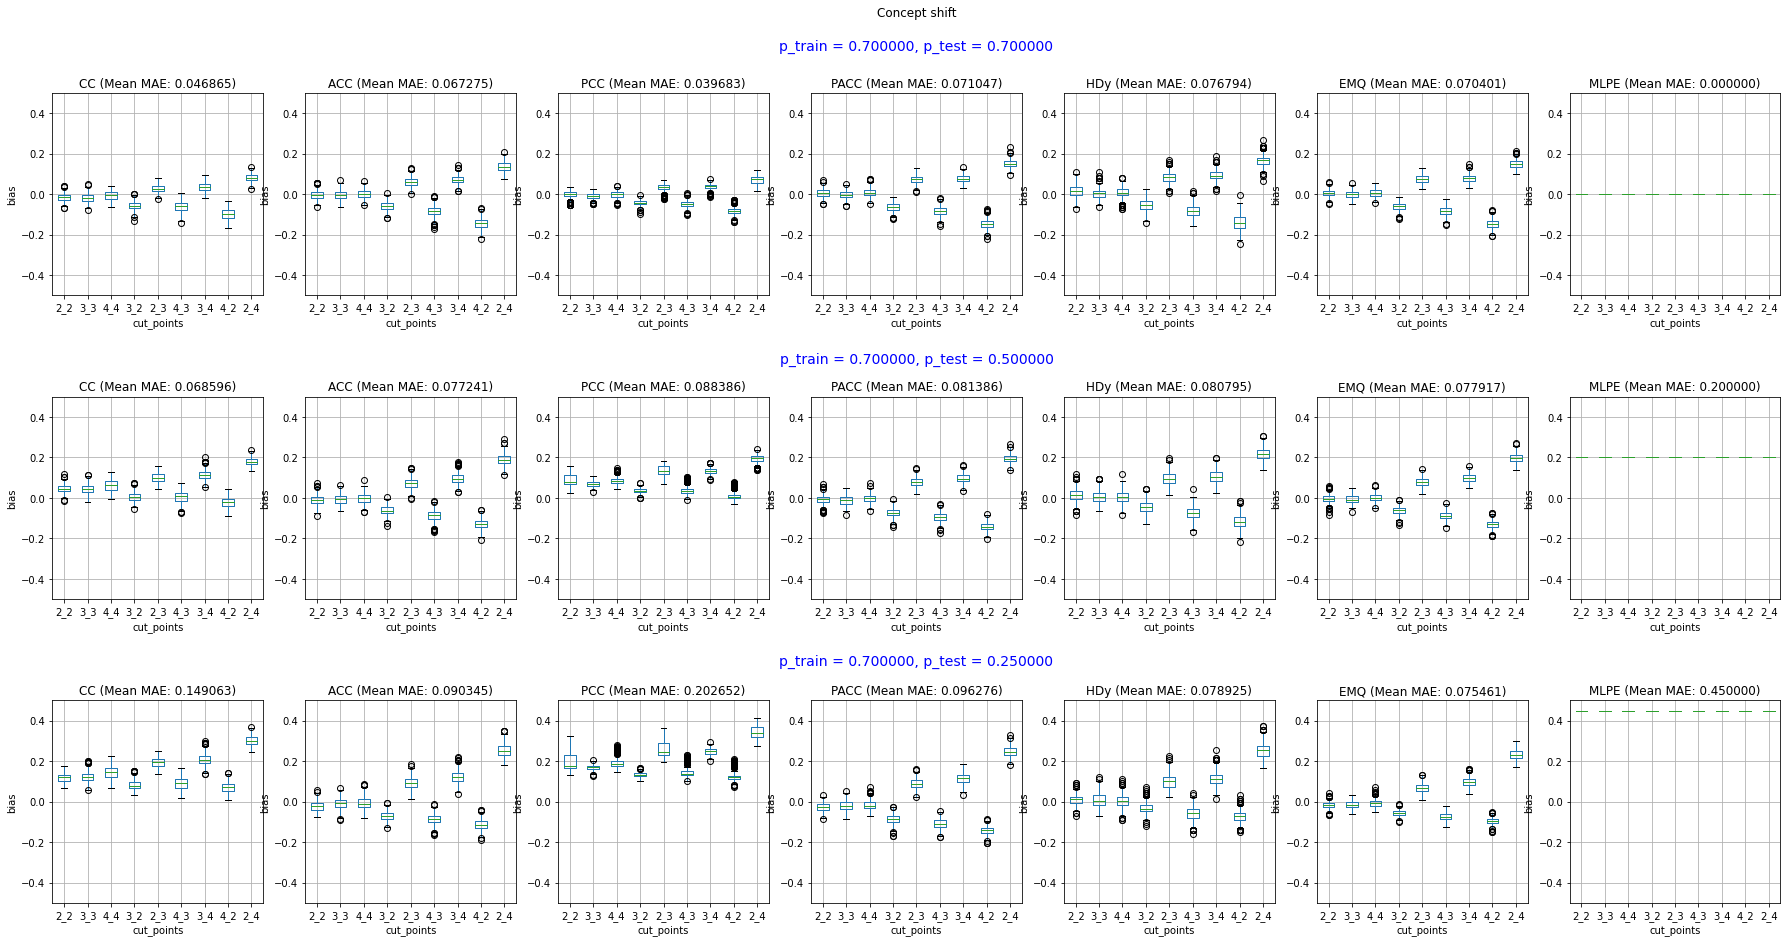

In [10]:
fig, ax = plt.subplots(len(ps_test),len(quantificators),figsize=(30,15))
plt.subplots_adjust(hspace=0.5)
for i, p_test in enumerate(ps_test):
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        ax[i][k].set_ylim(-0.5, 0.5)
        ax[i][k].set_ylabel(error)
        results.boxplot(ax=ax[i][k],column='error',by='cut_points')
        plt.suptitle('Concept shift')
        ax[i][k].set_title("%s (Mean %s: %f)"  % (quant_name,'MAE',mean_error_methods[exp_id]))

#Done by hand but I did not find an easy way
plt.figtext(0.5,0.95, "p_train = %f, p_test = %f" % (p_train,ps_test[0]), ha="center", va="top", fontsize=14, color="b")
plt.figtext(0.5,0.66, "p_train = %f, p_test = %f" % (p_train,ps_test[1]), ha="center", va="top", fontsize=14, color="b")
plt.figtext(0.5,0.38, "p_train = %f, p_test = %f" % (p_train,ps_test[2]), ha="center", va="top", fontsize=14, color="b")

### Tables and charts to be included in a paper

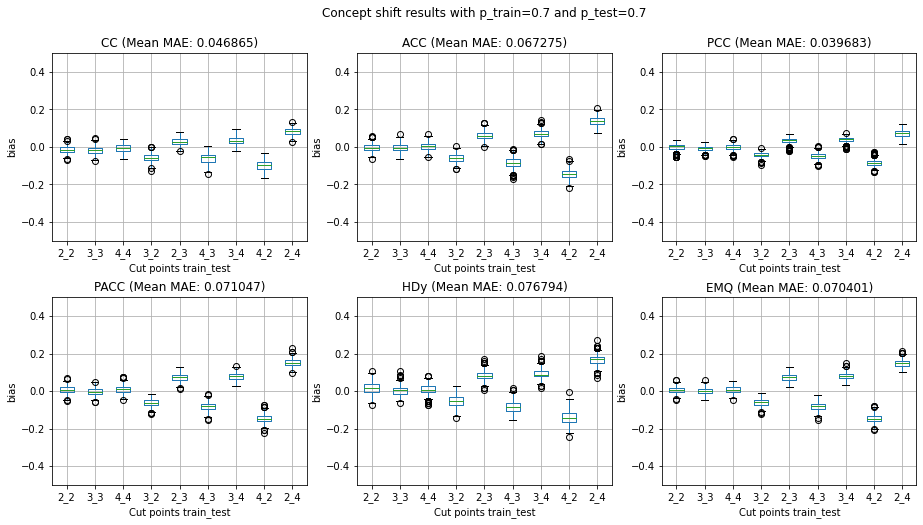

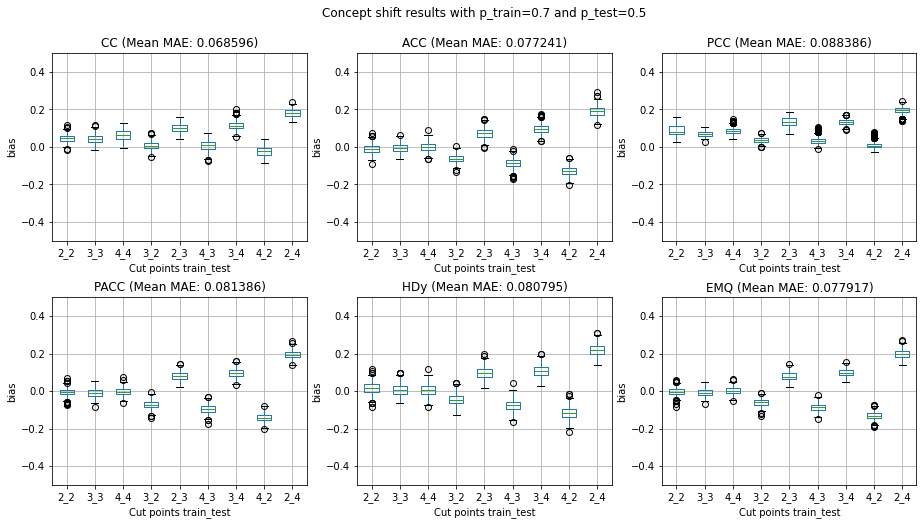

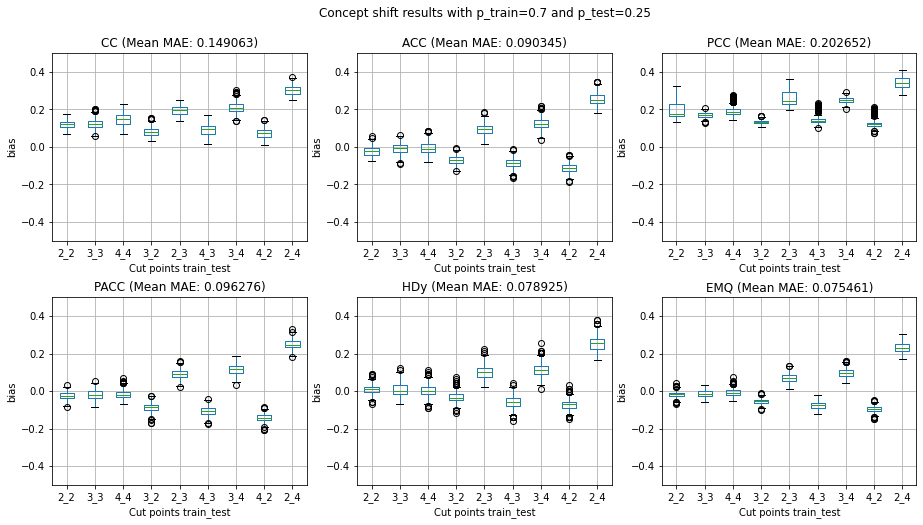

In [11]:
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy", "EMQ"]
for p_test in ps_test:
    fig, ax = plt.subplots(2,3,figsize=(15,8))
    plt.subplots_adjust(hspace=0.3)
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        ax[k//3][k%3].set_ylim(-0.5, 0.5)
        ax[k//3][k%3].set_ylabel(error)
        results.boxplot(ax=ax[k//3][k%3],column='error',by='cut_points')
        plt.suptitle('Concept shift results with p_train=0.7 and p_test={}'.format(p_test))
        ax[k//3][k%3].set_xlabel("Cut points train_test")
        ax[k//3][k%3].set_title("%s (Mean %s: %f)"  % (quant_name,'MAE',mean_error_methods[exp_id]))
    plt.savefig("images/concept{}.pdf".format(p_test),format='pdf')
    plt.savefig("images/concept{}.png".format(p_test),format='png')


## Shorter version of charts (Bias version)

Put a chart only with PCC and EMQ which are a representation of methods for concept shift

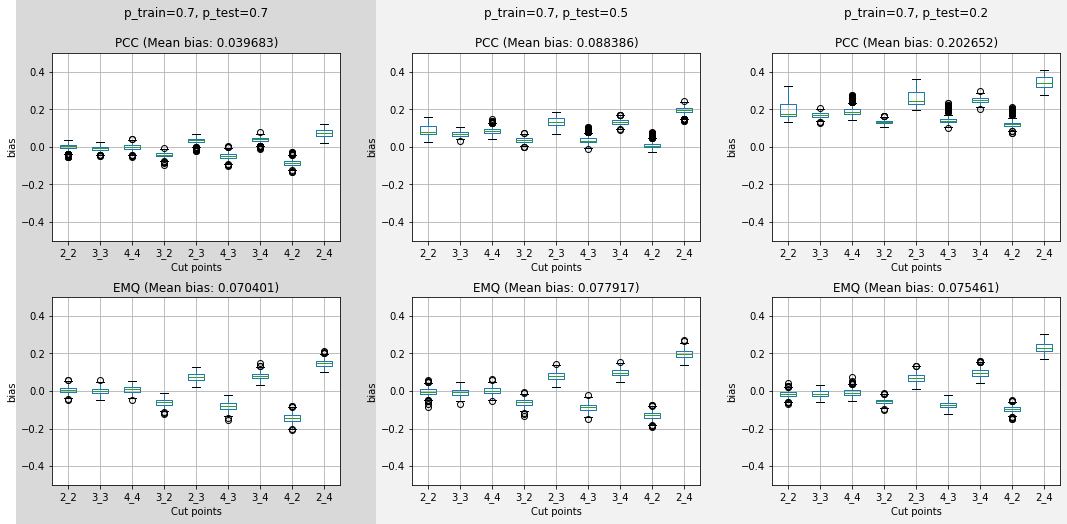

In [14]:
quantificators = ["PCC", "EMQ"]
fig = plt.figure(figsize=(15,8))
subfigs = fig.subfigures(ncols=3,wspace=2)
plt.subplots_adjust(hspace=0.3)
for j, p_test in enumerate(ps_test):
    axs = subfigs[j].subplots(nrows=2)
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        axs[k].set_ylim(-0.5, 0.5)
        axs[k].set_ylabel(error)
        results.boxplot(ax=axs[k],column='error',by='cut_points')
        axs[k].set_xlabel("Cut points")
        axs[k].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[exp_id]))
    subfigs[j].suptitle('p_train=0.7, p_test=%.1f' % p_test)

subfigs[0].set_facecolor('0.85')
subfigs[1].set_facecolor('0.95')
subfigs[2].set_facecolor('0.95')

plt.savefig("images/conceptsummary.pdf".format(p_test),format='pdf')
plt.savefig("images/conceptsummary.png".format(p_test),format='png')

## Shorter version of charts (MAE version)

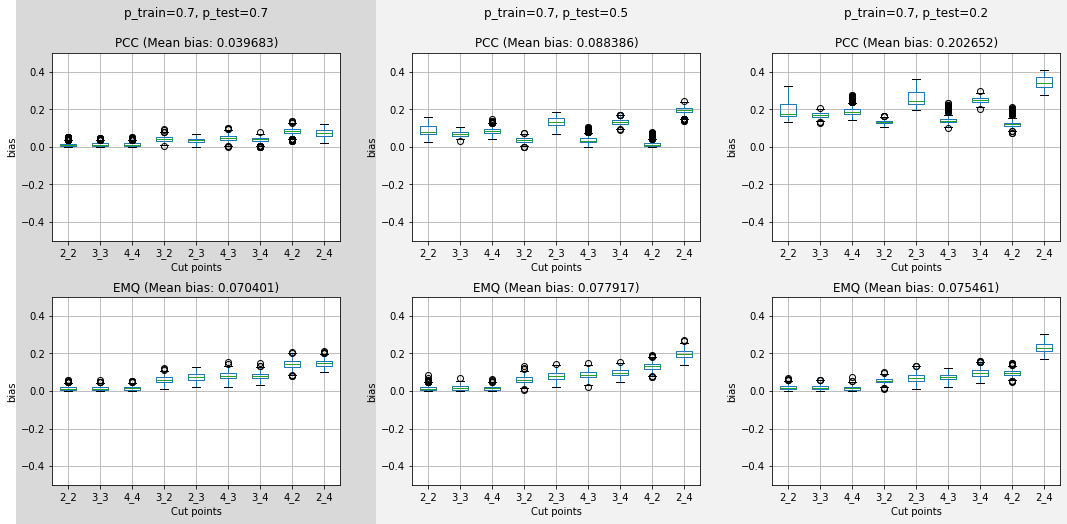

In [24]:
quantificators = ["PCC", "EMQ"]
fig = plt.figure(figsize=(15,8))
subfigs = fig.subfigures(ncols=3,wspace=2)
plt.subplots_adjust(hspace=0.3)
for j, p_test in enumerate(ps_test):
    axs = subfigs[j].subplots(nrows=2)
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        axs[k].set_ylim(-0.5, 0.5)
        axs[k].set_ylabel(error)
        results.boxplot(ax=axs[k],column='MAE',by='cut_points')
        axs[k].set_xlabel("Cut points")
        axs[k].set_title("%s (Mean %s: %f)"  % (quant_name,error,mean_error_methods[exp_id]))
    subfigs[j].suptitle('p_train=0.7, p_test=%.1f' % p_test)

subfigs[0].set_facecolor('0.85')
subfigs[1].set_facecolor('0.95')
subfigs[2].set_facecolor('0.95')

plt.savefig("images/conceptsummarymae.pdf".format(p_test),format='pdf')
plt.savefig("images/conceptsummarymae.png".format(p_test),format='png')

## Main table for concept shift in the paper (version with bias)

This table has the results for concept shift. It is meant to be in the main paper.

In [23]:
quantificators = ["CC", "ACC", "PCC", "PACC", "HDy", "EMQ"]
columns = pd.MultiIndex.from_product([["p_test={}".format(p_test) for p_test in ps_test],quantificators])
global_results = pd.DataFrame(columns = columns,index=order)
for i, p_test in enumerate(ps_test):
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        results = results.groupby(by=['cut_points'])['error'].mean()
        global_results.loc[:, (["p_test={}".format(p_test)], [quant_name])] = results

 

#In this case we want to highlight the smaller values in absolute value. We cannot use the functions hightlight_max or min. Need to compute them and then use set_properties
abs_results = global_results.abs()
global_results_style = global_results.style.format('{:.3f}')
for p_test in ps_test:
    mins = abs_results.loc[:,["p_test={}".format(p_test)]].idxmin(axis=1)
    for i,min in mins.iteritems():
        global_results_style = global_results_style.set_properties(subset=(i, min),**{'textbf':'--rwrap'})


display(global_results_style)
print(global_results_style.to_latex(multicol_align='c',hrules=True,column_format='l|rrrrrr|rrrrrr|rrrrrr').replace(' -0.',' -.').replace(' 0.',' +.').replace('{-0.','{-.').replace('{0.','{+.'))


\begin{tabular}{l|rrrrrr|rrrrrr|rrrrrr}
\toprule
 & \multicolumn{6}{c}{p_test=0.7} & \multicolumn{6}{c}{p_test=0.5} & \multicolumn{6}{c}{p_test=0.25} \\
 & CC & ACC & PCC & PACC & HDy & EMQ & CC & ACC & PCC & PACC & HDy & EMQ & CC & ACC & PCC & PACC & HDy & EMQ \\
\midrule
2_2 & -.013 & -.003 & \textbf{-.001} & +.006 & +.017 & +.006 & +.047 & -.011 & +.091 & -.006 & +.015 & \textbf{-.003} & +.119 & -.024 & +.203 & -.026 & \textbf{+.009} & -.017 \\
3_3 & -.017 & -.004 & -.008 & -.003 & +.003 & \textbf{-.000} & +.045 & -.006 & +.070 & -.011 & \textbf{+.006} & -.006 & +.123 & \textbf{-.008} & +.170 & -.020 & +.009 & -.014 \\
4_4 & -.006 & \textbf{+.002} & -.002 & +.008 & +.009 & +.007 & +.061 & -.001 & +.085 & -.002 & +.007 & \textbf{+.001} & +.145 & -.006 & +.192 & -.017 & \textbf{+.004} & -.008 \\
3_2 & -.055 & -.059 & \textbf{-.042} & -.063 & -.055 & -.060 & \textbf{+.008} & -.062 & +.036 & -.072 & -.046 & -.061 & +.084 & -.069 & +.133 & -.087 & \textbf{-.034} & -.055 \\
2_3 & \textbf{

## Main table for concept shift in the paper (version with AE)

This table has the results for concept shift. It is meant to be in the main paper.

In [22]:
from utils.wilcoxon import wilcoxon_test

quantificators = ["CC", "ACC", "PCC", "PACC", "HDy", "EMQ"]
columns = pd.MultiIndex.from_product([["p_test={}".format(p_test) for p_test in ps_test],quantificators])
global_results = pd.DataFrame(columns = columns,index=order)
for i, p_test in enumerate(ps_test):
    for k,quant_name in enumerate(quantificators):
        exp_id = "%s_%f" % (quant_name,p_test)
        results = results_dict[quant_name]
        results = results.loc[results['p_test'] == p_test]
        results = results.groupby(by=['cut_points'])['MAE'].mean()
        global_results.loc[:, (["p_test={}".format(p_test)], [quant_name])] = results

global_results_style = global_results.style.format('{:.3f}')

for i, p_test in enumerate(ps_test):
    #We want to make a statistical test for each row, to compare methods for the same degree of covariate shift
    for i,r in global_results.loc[:, (["p_test={}".format(p_test)])].iterrows():
        #compute the best method for this experiment
        cut_points = r.name
        best = r.index[r.argmin()]
        p_test = float(best[0][7:])
        best_method = best[1]
        #print("Computing statistical test for experiment covariate degree=%f, p_test=%s. Winner method %s" % (covariate_measure,p_test,best_method))
        #Get data for the winner method
        results_best = results_dict[best_method].loc[(results_dict[best_method]['p_test']==p_test) & (results_dict[best_method]['cut_points']==cut_points),'error'].to_numpy()
        #We need to get all the rows in results that matches this experiment for each method
        for quant_name in quantificators:
            if quant_name!=best_method:
                #print("Comparing %s with %s" % (best_method,quant_name))
                results_method = results_dict[quant_name].loc[(results_dict[quant_name]['p_test']==p_test) & (results_dict[quant_name]['cut_points']==cut_points),'error'].to_numpy()
                global_results_style.set_properties(subset=(cut_points, (best[0],quant_name)),**wilcoxon_test(results_best,results_method))



global_results_style = global_results_style.highlight_min(
    axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(ps_test[0])])).highlight_min(
    axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(ps_test[1])])).highlight_min(
    axis=1,props='textbf:--rwrap;',subset=(["p_test={}".format(ps_test[2])]))
display(global_results_style)
print(global_results_style.to_latex(hrules=True,multicol_align='c',column_format='l|rrrrrr|rrrrrr|rrrrrr').replace(' 0.',' .').replace('{0.','{.'))

\begin{tabular}{l|rrrrrr|rrrrrr|rrrrrr}
\toprule
 & \multicolumn{6}{c}{p_test=0.7} & \multicolumn{6}{c}{p_test=0.5} & \multicolumn{6}{c}{p_test=0.25} \\
 & CC & ACC & PCC & PACC & HDy & EMQ & CC & ACC & PCC & PACC & HDy & EMQ & CC & ACC & PCC & PACC & HDy & EMQ \\
\midrule
2_2 & .018 & \dag{.017} & \textbf{.013} & .016 & .026 & .015 & .047 & .020 & .091 & .017 & .026 & \textbf{.015} & .119 & .027 & .203 & .027 & .020 & \textbf{.020} \\
3_3 & .023 & .018 & \textbf{.013} & .015 & .021 & .015 & .045 & \ddag{.020} & .070 & .020 & .024 & \textbf{.018} & .123 & .022 & .170 & .026 & .026 & \textbf{.020} \\
4_4 & \dag{.019} & .017 & \textbf{.013} & .017 & .023 & .016 & .061 & \dag{.020} & .085 & .017 & .026 & \textbf{.016} & .145 & \ddag{.026} & .192 & .025 & .024 & \textbf{.016} \\
3_2 & .055 & .059 & \textbf{.042} & .063 & .056 & .060 & \textbf{.018} & .062 & .036 & .072 & .048 & .061 & .084 & .069 & .133 & .087 & \textbf{.038} & .055 \\
2_3 & \textbf{.030} & .061 & .034 & .073 & .084 & .073